# UoA - Group 1 - Capstone Project
Date Last Updated: August 7

## Init

Initialize the model to use the appropiate dataset (PubMed) and Metagraph (P-->P<--P). Also install all relevant libraries needed.

__Configuration:__

*   Only Dataset: PubMed
*   Baseline Mode Metagraph (P-->P<--P): PRP


In [4]:
# Connect to Goolgle drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


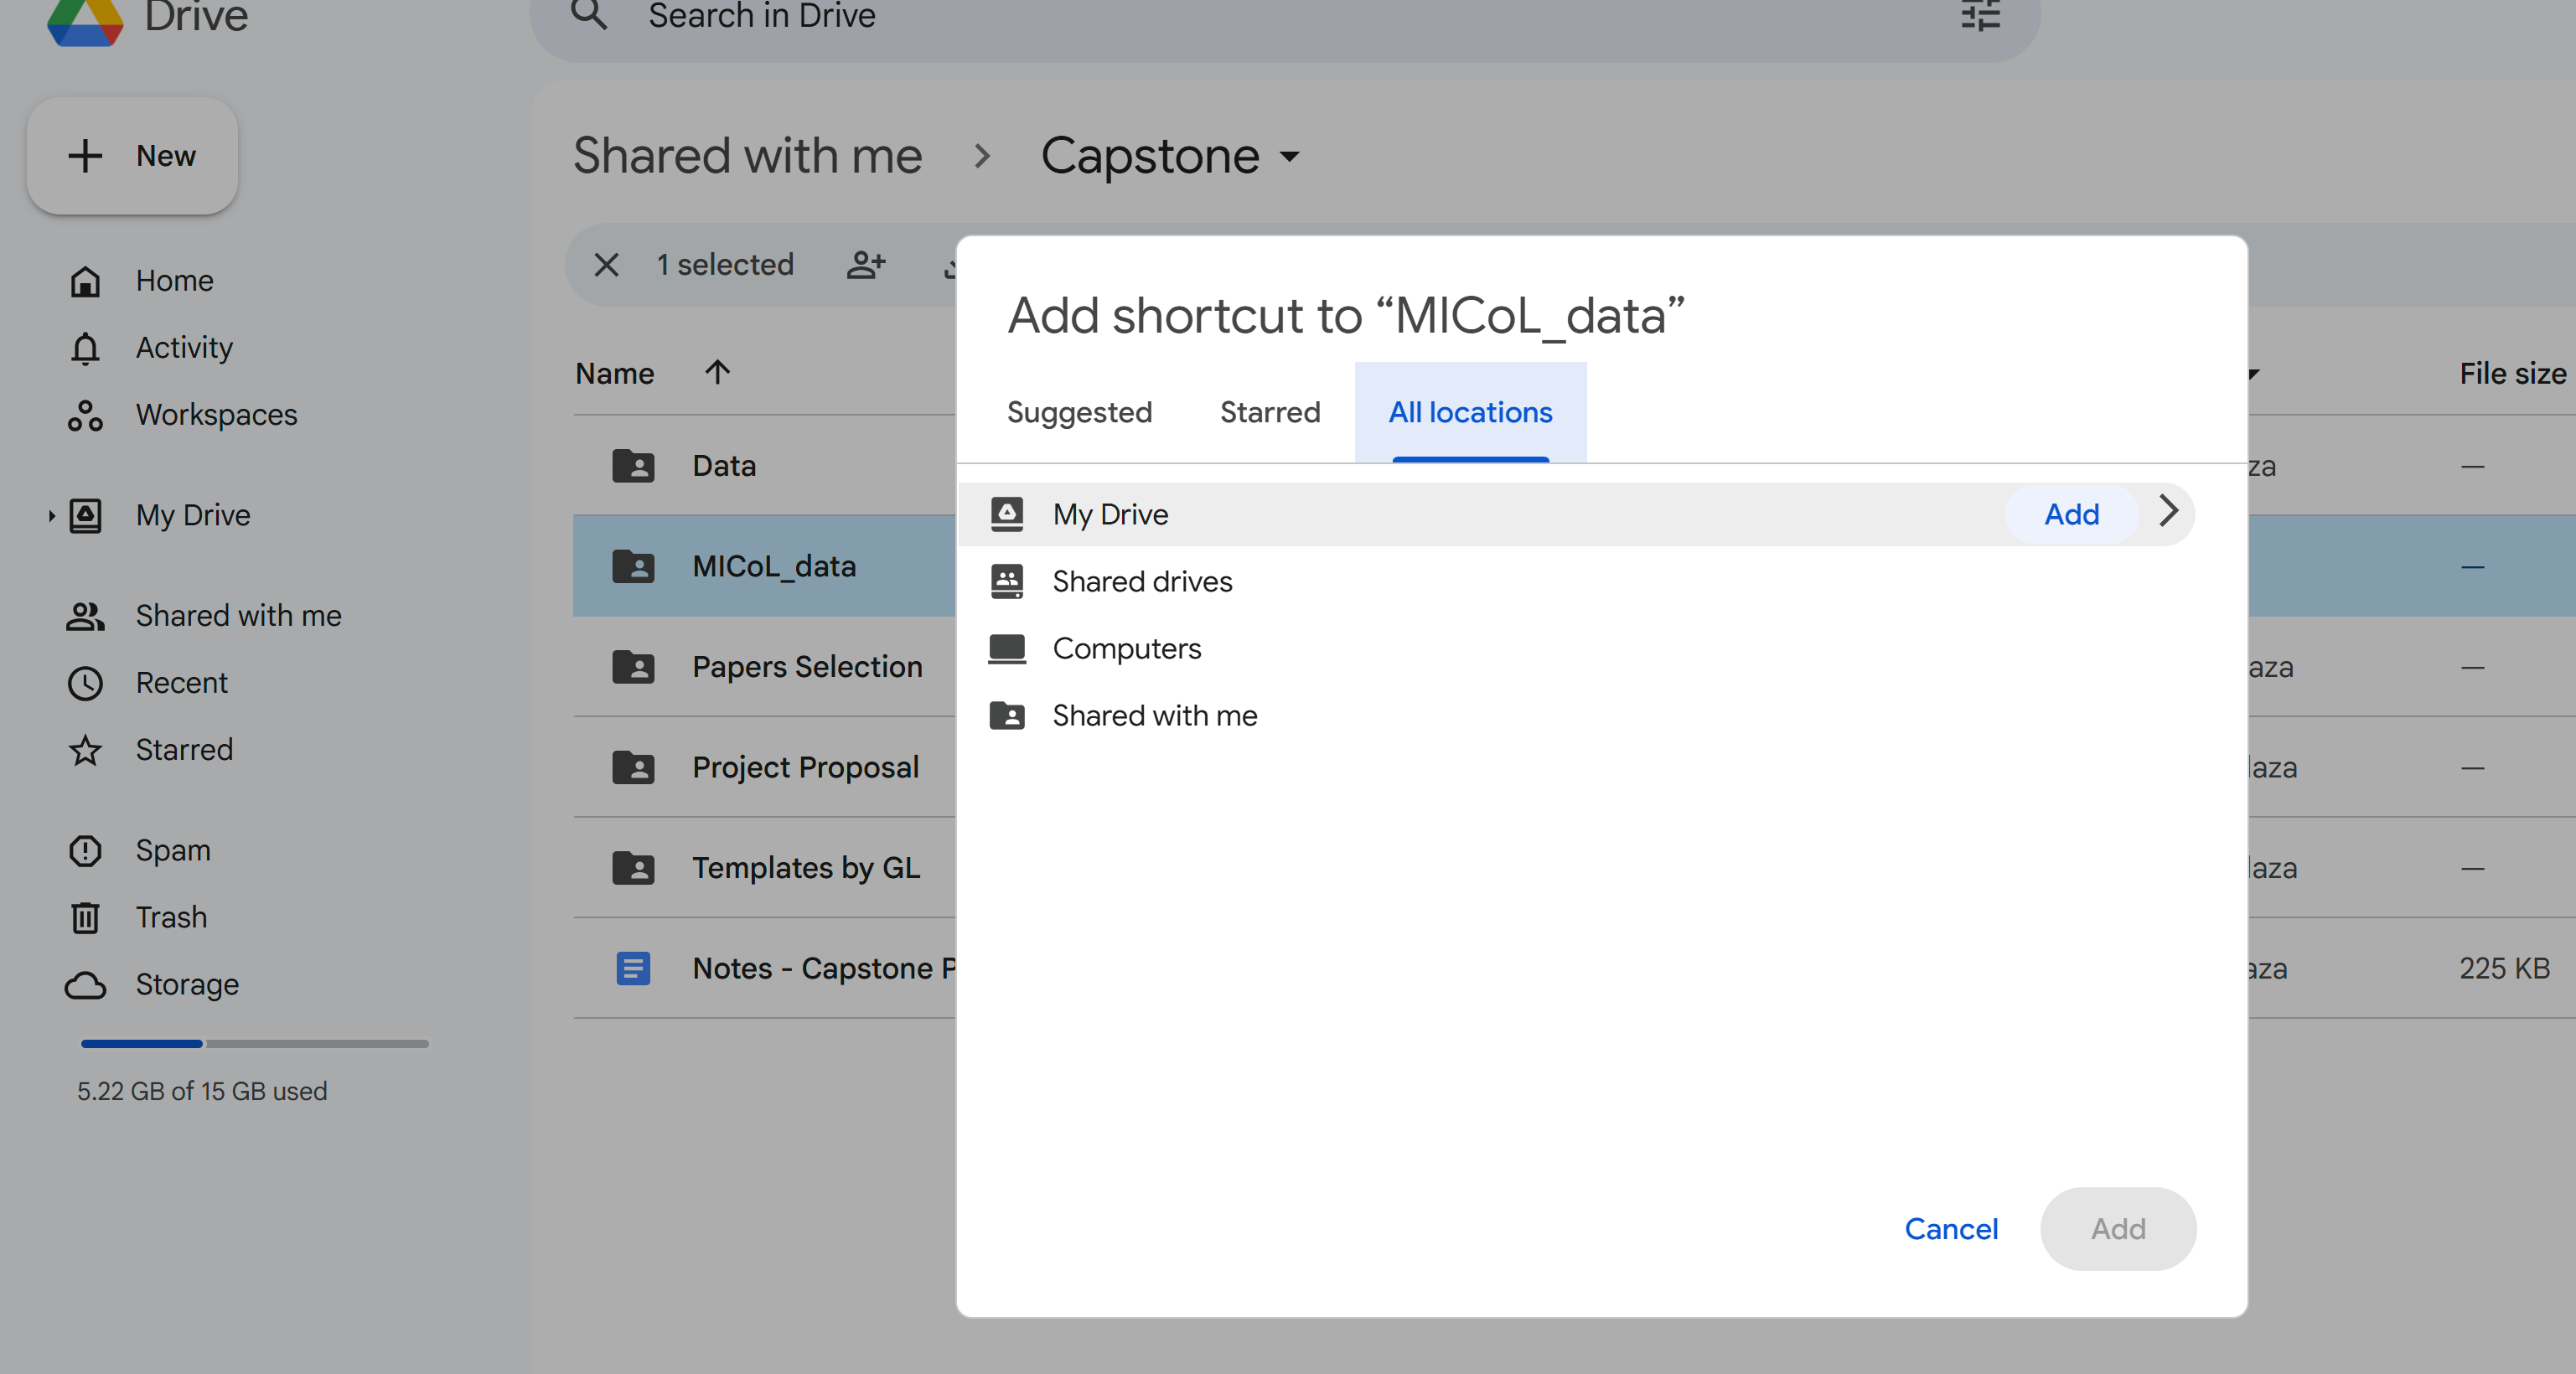

In [5]:
#Set dataset and Metagraph for the model. This is the best performing combination in the papel literature.

dataset='PubMed'              # Selected PubDataset
metagraph='PRP'               # Selected the metagraph that perform best in the paper to get started
architecture = 'cross'        # Best performing model encoder architecture

In [6]:
'''
Install and import all Requirements:
numpy==1.18.5
scipy==1.2.1
scikit-learn==0.23.1
torch==1.6.0
torchvision==0.7.0
transformers==3.0.2
tqdm==4.31.1
'''

!pip install numpy scipy scikit-learn torch torchvision transformers tqdm sentence-transformers
!pip install transformers==4.54.0
!pip install torch
!git clone https://github.com/NVIDIA/apex
!cd apex && pip install -v --disable-pip-version-check --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

from huggingface_hub import snapshot_download
import os
import json
from tqdm import tqdm
import argparse
from collections import defaultdict
import random



fatal: destination path 'apex' already exists and is not an empty directory.
Using pip 24.1.2 from /usr/local/lib/python3.11/dist-packages/pip (python 3.11)
DEPRECATION: --build-option and --global-option are deprecated. pip 24.2 will enforce this behaviour change. A possible replacement is to use --config-settings. Discussion can be found at https://github.com/pypa/pip/issues/11859
Processing /content/apex
  Running command pip subprocess to install build dependencies
  Using pip 24.1.2 from /usr/local/lib/python3.11/dist-packages/pip (python 3.11)
  Non-user install by explicit request
  Created build tracker: /tmp/pip-build-tracker-2qaju9is
  Entered build tracker: /tmp/pip-build-tracker-2qaju9is
  Created temporary directory: /tmp/pip-install-has8c5a9
  Created temporary directory: /tmp/pip-ephem-wheel-cache-rznowvu4
  1 location(s) to search for versions of setuptools:
  * https://pypi.org/simple/setuptools/
  Fetching project page and analyzing links: https://pypi.org/simple/setu

# Prepare.sh

Prepare dataset to be used in training and validation

Process:

1.  Prepare test data  (prepare_test.py)
2.  Prepare train data (prepare_train.py)
3.  Store first 100,000 rows of *PubMed/dataset.txt*  into **train.txt**
4.  Store last 10,000 rows of *PubMed/dataset.txt*  into **dev.txt**

##  Prepare Test Data

There is no need more modification of this script.




In [7]:
# Make PubMed_input/ directory
if not os.path.exists(f'{dataset}_input/'):
        os.mkdir(f'{dataset}_input/')

drive_dataset_path = f'/content/drive/MyDrive/Capstone/MICoL_data/PubMed' # <--- Make sure this path is correct for your dataset in Drive

### List of Team's Directory for easy reference

    #FP's Pad: drive_dataset_path = f'/content/drive/MyDrive/Capstone/MICoL_data/PubMed'
    #JP's Pad: drive_dataset_path = f'/content/drive/MyDrive/MICoL_data/PubMed' # <--- Make sure this path is correct for your dataset in Drive

In [8]:
#Install Libraries
import json
from tqdm import tqdm

#Load test document into memory
doc2text = {}
with open(f'{drive_dataset_path}/{dataset}_test.json') as fin:
  for line in tqdm(fin):
    data = json.loads(line)
    doc = data['paper']
    text = data['text'].replace('_', ' ')
    doc2text[doc] = text


89854it [00:05, 17306.23it/s]


In [9]:
#Load Label text into Memory

label2text = {}
with open(f'{drive_dataset_path}/{dataset}_label.json') as fin:
    for line in tqdm(fin):
                data = json.loads(line)
                label = data['label']
                text = data['combined_text']
                label2text[label] = text


17963it [00:01, 15758.45it/s]


In [10]:
# Map label candidates to documents. Generate PubMed_input/test.txt

with open(f'{drive_dataset_path}/{dataset}_candidates.json') as fin, open(f'{dataset}_input/test.txt', 'w') as fout:
        for line in tqdm(fin):
                data = json.loads(line)
                doc_text = doc2text[data['paper']]
                labels = data['predicted_label']
                for label in labels:
                        label_text = label2text[label]
                        fout.write(f'1\t{doc_text}\t{label_text}\n')

89854it [00:03, 23902.37it/s]


## Prepare Train Data

This is where we will need to create another script to create the label pairs

In [11]:
#Import relevant libraries
import json
import argparse
import os
from collections import defaultdict
import random
from tqdm import tqdm

### Functions Definitions

In [12]:
#This function could be reutilized for label-pairs
# P->P and P<-P
def no_intermediate_node(dataset, doc2text, docs, metadata):
        meta2doc = defaultdict(set)
        doc2meta = {}
        with open(f'{drive_dataset_path}/{dataset}_train.json') as fin:
                for idx, line in enumerate(tqdm(fin)):
                        data = json.loads(line)
                        doc = data['paper']

                        metas = data[metadata]
                        if not isinstance(metas, list):
                                metas = [metas]
                        for meta in metas:
                                meta2doc[meta].add(doc)
                        doc2meta[doc] = set(metas)

        with open(f'{dataset}_input/dataset.txt', 'w') as fout:
                for idx, doc in enumerate(tqdm(doc2meta)):
                        # sample positive
                        dps = [x for x in doc2meta[doc] if x in doc2text]
                        if len(dps) == 0:
                                continue
                        dp = random.choice(dps)

                        # sample negative
                        while True:
                                dn = random.choice(docs)
                                if dn != doc and dn != dp:
                                        break

                        fout.write(f'1\t{doc2text[doc]}\t{doc2text[dp]}\n')
                        fout.write(f'0\t{doc2text[doc]}\t{doc2text[dn]}\n')

In [13]:
#Create label pairs

# PAP, PVP, P->P<-P, and P<-P->P
def one_intermediate_node(dataset, doc2text, docs, metadata):
  meta2doc = defaultdict(set)
  doc2meta = {}
  with open(f'{drive_dataset_path}/{dataset}_train.json') as fin:
    for idx, line in enumerate(tqdm(fin)):
      data = json.loads(line)
      doc = data['paper']

      metas = data[metadata]
      if not isinstance(metas, list):
              metas = [metas]
      for meta in metas:
              meta2doc[meta].add(doc)
      doc2meta[doc] = set(metas)

  with open(f'{dataset}_input/dataset.txt', 'w') as fout:
          for idx, doc in enumerate(tqdm(doc2meta)):
                  # sample positive
                  metas = doc2meta[doc]
                  dps = []
                  for meta in metas:
                          candidates = list(meta2doc[meta])
                          if len(candidates) > 1:
                                  while True:
                                          dp = random.choice(candidates)
                                          if dp != doc:
                                                  dps.append(dp)
                                                  break
                  if len(dps) == 0:
                          continue
                  dp = random.choice(dps)

                  # sample negative
                  while True:
                          dn = random.choice(docs)
                          if dn != doc and dn != dp:
                                  break

                  fout.write(f'1\t{doc2text[doc]}\t{doc2text[dp]}\n')
                  fout.write(f'0\t{doc2text[doc]}\t{doc2text[dn]}\n')

In [14]:
#Not Needed for what we need to do / Could be removed if needed

# P(AA)P, P(AV)P, P->(PP)<-P, and P<-(PP)->P
def two_intermediate_node(dataset, doc2text, docs, metadata1, metadata2):
        meta12doc = defaultdict(set)
        doc2meta1 = {}
        doc2meta2 = {}
        with open(f'{drive_dataset_path}/{dataset}_train.json') as fin:
                for idx, line in enumerate(tqdm(fin)):
                        data = json.loads(line)
                        doc = data['paper']

                        meta1s = data[metadata1]
                        if not isinstance(meta1s, list):
                                meta1s = [meta1s]
                        for meta1 in meta1s:
                                meta12doc[meta1].add(doc)
                        doc2meta1[doc] = set(meta1s)

                        meta2s = data[metadata2]
                        if not isinstance(meta2s, list):
                                meta2s = [meta2s]
                        doc2meta2[doc] = set(meta2s)

        with open(f'{dataset}_input/dataset.txt', 'w') as fout:
                for idx, doc in enumerate(tqdm(doc2meta1)):
                        # sample positive
                        meta1s = doc2meta1[doc]
                        dps = []
                        for meta1 in meta1s:
                                candidates = []
                                for d_cand in list(meta12doc[meta1]):
                                        if d_cand == doc:
                                                continue
                                        meta_intersec = doc2meta2[doc].intersection(doc2meta2[d_cand])
                                        if metadata1 != metadata2:
                                                if len(meta_intersec) >= 1:
                                                        candidates.append(d_cand)
                                        else:
                                                if len(meta_intersec) >= 2:
                                                        candidates.append(d_cand)
                                if len(candidates) > 1:
                                        while True:
                                                dp = random.choice(candidates)
                                                if dp != doc:
                                                        dps.append(dp)
                                                        break
                        if len(dps) == 0:
                                continue
                        dp = random.choice(dps)

                        # sample negative
                        while True:
                                dn = random.choice(docs)
                                if dn != doc and dn != dp:
                                        break

                        fout.write(f'1\t{doc2text[doc]}\t{doc2text[dp]}\n')
                        fout.write(f'0\t{doc2text[doc]}\t{doc2text[dn]}\n')

### Execution of functions

In [15]:
# Load papers and ids
doc2text = {}
docs = []
with open(f'{drive_dataset_path}/{dataset}_train.json') as fin:
        for idx, line in enumerate(tqdm(fin)):
                data = json.loads(line)
                doc = data['paper']
                text = data['text'].replace('_', ' ')
                doc2text[doc] = text
                docs.append(doc)

808692it [00:22, 35325.11it/s]


In [16]:
# Run functions based on metagraph definitions - Generate dataset.txt
# P->P
if metagraph == 'PR':
	no_intermediate_node(dataset, doc2text, docs, 'reference')
# P<-P
elif metagraph == 'PC':
	no_intermediate_node(dataset, doc2text, docs, 'citation')
# PAP
elif metagraph == 'PAP':
	one_intermediate_node(dataset, doc2text, docs, 'author')
# PVP
elif metagraph == 'PVP':
	one_intermediate_node(dataset, doc2text, docs, 'venue')
# P->P<-P
elif metagraph == 'PRP':
	one_intermediate_node(dataset, doc2text, docs, 'reference')
# P<-P->P
elif metagraph == 'PCP':
	one_intermediate_node(dataset, doc2text, docs, 'citation')
# P(AA)P
elif metagraph == 'PAAP':
	two_intermediate_node(dataset, doc2text, docs, 'author', 'author')
# P(AV)P
elif metagraph == 'PAVP':
	two_intermediate_node(dataset, doc2text, docs, 'author', 'venue')
# P->(PP)<-P
elif metagraph == 'PRRP':
	two_intermediate_node(dataset, doc2text, docs, 'reference', 'reference')
# P<-(PP)->P
elif metagraph == 'PCCP':
	two_intermediate_node(dataset, doc2text, docs, 'citation', 'citation')
else:
	print('Wrong Meta-path/Meta-graph!!')

808692it [00:15, 51309.27it/s]
100%|██████████| 808692/808692 [00:20<00:00, 40115.30it/s]


In [17]:
#Generate train.txt and dev.txt

import subprocess


# Dataset is defined elsewhere in the notebook

# Execute the first command
subprocess.run(f"head -100000 {dataset}_input/dataset.txt > {dataset}_input/train.txt", shell=True, check=True)

# Execute the second command
subprocess.run(f"sed -n '100001,110000p' {dataset}_input/dataset.txt > {dataset}_input/dev.txt", shell=True, check=True)

CompletedProcess(args="sed -n '100001,110000p' PubMed_input/dataset.txt > PubMed_input/dev.txt", returncode=0)

# Run.sh



1. Main training (First Pass)
2. Evaluation Training (Second Pass)
3. Postprocess
4. Compute evaluation Metrics



## Dependancy Imports - Functions

### transform.py

This code defines three text preprocessing classes for a BERT-based selection/ranking model. Each class handles text tokenization differently for various input scenarios.


In [18]:
#Processes multiple texts independently, each padded to the same maximum length.
class SelectionSequentialTransform(object):
	def __init__(self, tokenizer, max_len):
		self.tokenizer = tokenizer
		self.max_len = max_len

	def __call__(self, texts):
		input_ids_list, segment_ids_list, input_masks_list, contexts_masks_list = [], [], [], []
		for text in texts:
			tokenized_dict = self.tokenizer.encode_plus(text, max_length=self.max_len, pad_to_max_length=True)
			input_ids, input_masks = tokenized_dict['input_ids'], tokenized_dict['attention_mask']
			assert len(input_ids) == self.max_len
			assert len(input_masks) == self.max_len
			input_ids_list.append(input_ids)
			input_masks_list.append(input_masks)

		return input_ids_list, input_masks_list

#Purpose: Processes a single text string.
class SelectionJoinTransform(object):
	def __init__(self, tokenizer, max_len):
		self.tokenizer = tokenizer
		self.max_len = max_len

	def __call__(self, text):
		tokenized_dict = self.tokenizer.encode_plus(text, max_length=self.max_len, pad_to_max_length=True)
		input_ids, input_masks = tokenized_dict['input_ids'], tokenized_dict['attention_mask']
		assert len(input_ids) == self.max_len
		assert len(input_masks) == self.max_len

		return input_ids, input_masks

# Concatenates a context with multiple response candidates, creating context-response pairs.
class SelectionConcatTransform(object):
	def __init__(self, tokenizer, max_response_len, max_contexts_len):
		self.tokenizer = tokenizer
		self.max_response_len = max_response_len
		self.max_contexts_len = max_contexts_len
		self.max_len = max_response_len + max_contexts_len

	def __call__(self, context, responses):
		tokenized_dict = self.tokenizer.encode_plus(context, max_length=self.max_contexts_len)
		context_ids, context_masks, context_segment_ids = tokenized_dict['input_ids'], tokenized_dict['attention_mask'], tokenized_dict['token_type_ids']
		ret_input_ids = []
		ret_input_masks = []
		ret_segment_ids = []
		for response in responses:
			tokenized_dict = self.tokenizer.encode_plus(response, max_length=self.max_response_len+1)
			response_ids, response_masks, response_segment_ids = tokenized_dict['input_ids'], tokenized_dict['attention_mask'], tokenized_dict['token_type_ids']
			input_ids = context_ids + response_ids[1:]
			input_masks = context_masks + response_masks[1:]
			input_segment_ids = context_segment_ids + [1]*(len(response_segment_ids)-1)
			input_ids += [0] * (self.max_len - len(input_ids))
			input_masks += [0] * (self.max_len - len(input_masks))
			input_segment_ids += [0] * (self.max_len - len(input_segment_ids))
			assert len(input_ids) == self.max_len
			assert len(input_masks) == self.max_len
			assert len(input_segment_ids) == self.max_len
			ret_input_ids.append(input_ids)
			ret_input_masks.append(input_masks)
			ret_segment_ids.append(input_segment_ids)

		return ret_input_ids, ret_input_masks, ret_segment_ids


### dataset.py
This code defines a PyTorch Dataset class for response selection/ranking tasks. It's designed to handle datasets where you have contexts paired with multiple response candidates, each labeled as correct (1) or incorrect (0).

In [19]:
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
import os
import random
import pickle
from google.colab import drive

repo_dataset_path = '/content/'

class SelectionDataset(Dataset):

        # Initialize

        def __init__(self, file_path, context_transform, response_transform, concat_transform, sample_cnt=None, mode='poly'):
                self.context_transform = context_transform
                self.response_transform = response_transform
                self.concat_transform = concat_transform
                self.data_source = []
                self.mode = mode
                neg_responses = []
                # Construct the full path using repo_dataset_path
                full_file_path = os.path.join(repo_dataset_path, file_path)
                with open(full_file_path, encoding='utf-8') as f:
                        group = {
                                'context': None,
                                'responses': [],
                                'labels': []
                        }
                        for line in f:
                                split = line.strip().split('\t')
                                lbl, context, response = int(split[0]), split[1], split[2]
                                if lbl == 1 and len(group['responses']) > 0:
                                        self.data_source.append(group)
                                        group = {
                                                'context': None,
                                                'responses': [],
                                                'labels': []
                                        }
                                        if sample_cnt is not None and len(self.data_source) >= sample_cnt:
                                                break
                                else:
                                        neg_responses.append(response)
                                group['responses'].append(response)
                                group['labels'].append(lbl)
                                group['context'] = context
                        if len(group['responses']) > 0:
                                self.data_source.append(group)

        def __len__(self):
                return len(self.data_source)

        def __getitem__(self, index):
                group = self.data_source[index]
                context, responses, labels = group['context'], group['responses'], group['labels']
                if self.mode == 'cross':
                        transformed_text = self.concat_transform(context, responses)
                        ret = transformed_text, labels
                else:
                        transformed_context = self.context_transform(context)  # [token_ids],[seg_ids],[masks]
                        transformed_responses = self.response_transform(responses)  # [token_ids],[seg_ids],[masks]
                        ret = transformed_context, transformed_responses, labels

                return ret

        #Create batches

        def batchify_join_str(self, batch):
                if self.mode == 'cross':
                        text_token_ids_list_batch, text_input_masks_list_batch, text_segment_ids_list_batch = [], [], []
                        labels_batch = []
                        for sample in batch:
                                text_token_ids_list, text_input_masks_list, text_segment_ids_list = sample[0]

                                text_token_ids_list_batch.append(text_token_ids_list)
                                text_input_masks_list_batch.append(text_input_masks_list)
                                text_segment_ids_list_batch.append(text_segment_ids_list)

                                labels_batch.append(sample[1])

                        long_tensors = [text_token_ids_list_batch, text_input_masks_list_batch, text_segment_ids_list_batch]

                        text_token_ids_list_batch, text_input_masks_list_batch, text_segment_ids_list_batch = (
                                torch.tensor(t, dtype=torch.long) for t in long_tensors)

                        labels_batch = torch.tensor(labels_batch, dtype=torch.long)
                        return text_token_ids_list_batch, text_input_masks_list_batch, text_segment_ids_list_batch, labels_batch

                else:
                        contexts_token_ids_list_batch, contexts_input_masks_list_batch, \
                        responses_token_ids_list_batch, responses_input_masks_list_batch = [], [], [], []
                        labels_batch = []
                        for sample in batch:
                                (contexts_token_ids_list, contexts_input_masks_list), (responses_token_ids_list, responses_input_masks_list) = sample[:2]

                                contexts_token_ids_list_batch.append(contexts_token_ids_list)
                                contexts_input_masks_list_batch.append(contexts_input_masks_list)

                                responses_token_ids_list_batch.append(responses_token_ids_list)
                                responses_input_masks_list_batch.append(responses_input_masks_list)

                                labels_batch.append(sample[-1])

                        long_tensors = [contexts_token_ids_list_batch, contexts_input_masks_list_batch,
                                                                                        responses_token_ids_list_batch, responses_input_masks_list_batch]

                        contexts_token_ids_list_batch, contexts_input_masks_list_batch, \
                        responses_token_ids_list_batch, responses_input_masks_list_batch = (
                                torch.tensor(t, dtype=torch.long) for t in long_tensors)

                        labels_batch = torch.tensor(labels_batch, dtype=torch.long)
                        return contexts_token_ids_list_batch, contexts_input_masks_list_batch, \
                                                  responses_token_ids_list_batch, responses_input_masks_list_batch, labels_batch

### encoder.py
This code implements three different BERT-based architectures for response selection tasks. Each represents a different approach to encoding and matching contexts with responses.

In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertPreTrainedModel, BertModel

#Context and responses are encoded independently by BERT
class BiEncoder(BertPreTrainedModel):
	def __init__(self, config, *inputs, **kwargs):
		super().__init__(config, *inputs, **kwargs)
		self.bert = kwargs['bert']

	def forward(self, context_input_ids, context_input_masks,
				responses_input_ids, responses_input_masks, labels=None):
		temperature = 0.05

		# during training, only select the first response; using other instances in a batch as negative examples
		if labels is not None:
			responses_input_ids = responses_input_ids[:, 0, :].unsqueeze(1)
			responses_input_masks = responses_input_masks[:, 0, :].unsqueeze(1)

		context_vec = self.bert(context_input_ids, context_input_masks)[0][:,0,:]  # [bs, dim]
		context_vec = F.normalize(context_vec, dim=1)

		batch_size, res_cnt, seq_length = responses_input_ids.shape
		responses_input_ids = responses_input_ids.view(-1, seq_length)
		responses_input_masks = responses_input_masks.view(-1, seq_length)

		responses_vec = self.bert(responses_input_ids, responses_input_masks)[0][:,0,:]  # [bs, dim]
		responses_vec = responses_vec.view(batch_size, res_cnt, -1)
		responses_vec = F.normalize(responses_vec, dim=2)

		if labels is not None:
			responses_vec = responses_vec.squeeze(1)
			dot_product = torch.matmul(context_vec, responses_vec.t()) / temperature  # [bs, bs]
			mask = torch.eye(context_input_ids.size(0)).to(context_input_ids.device)
			loss = F.log_softmax(dot_product, dim=-1) * mask
			loss = (-loss.sum(dim=1)).mean()
			return loss
		else:
			context_vec = context_vec.unsqueeze(1)
			dot_product = torch.matmul(context_vec, responses_vec.permute(0, 2, 1)).squeeze()
			return dot_product

#Context and response concatenated as [CLS] context [SEP] response [SEP]
class CrossEncoder(BertPreTrainedModel):
	def __init__(self, config, *inputs, **kwargs):
		super().__init__(config, *inputs, **kwargs)
		self.bert = kwargs['bert']
		self.linear = nn.Linear(config.hidden_size, 1)

	def forward(self, text_input_ids, text_input_masks, text_input_segments, labels=None):
		batch_size, neg, dim = text_input_ids.shape
		text_input_ids = text_input_ids.reshape(-1, dim)
		text_input_masks = text_input_masks.reshape(-1, dim)
		text_input_segments = text_input_segments.reshape(-1, dim)
		text_vec = self.bert(text_input_ids, text_input_masks, text_input_segments)[0][:,0,:]  # [bs, dim]
		score = self.linear(text_vec)
		score = score.view(-1, neg)
		if labels is not None:
			loss = -F.log_softmax(score, -1)[:,0].mean()
			return loss
		else:
			return score

# Uses m learnable "poly codes" to create multiple context representations / Not active in our code
class PolyEncoder(BertPreTrainedModel):
	def __init__(self, config, *inputs, **kwargs):
		super().__init__(config, *inputs, **kwargs)
		self.bert = kwargs['bert']
		self.poly_m = kwargs['poly_m']
		self.poly_code_embeddings = nn.Embedding(self.poly_m, config.hidden_size)
		torch.nn.init.normal_(self.poly_code_embeddings.weight, config.hidden_size ** -0.5)

	def dot_attention(self, q, k, v):
		# q: [bs, poly_m, dim] or [bs, res_cnt, dim]
		# k=v: [bs, length, dim] or [bs, poly_m, dim]
		attn_weights = torch.matmul(q, k.transpose(2, 1)) # [bs, poly_m, length]
		attn_weights = F.softmax(attn_weights, -1)
		output = torch.matmul(attn_weights, v) # [bs, poly_m, dim]
		return output

	def forward(self, context_input_ids, context_input_masks,
				responses_input_ids, responses_input_masks, labels=None):
		temperature = 0.05

		# during training, only select the first response; using other instances in a batch as negative examples
		if labels is not None:
			responses_input_ids = responses_input_ids[:, 0, :].unsqueeze(1)
			responses_input_masks = responses_input_masks[:, 0, :].unsqueeze(1)
		batch_size, res_cnt, seq_length = responses_input_ids.shape  # res_cnt is 1 during training

		# context encoder
		ctx_out = self.bert(context_input_ids, context_input_masks)[0]  # [bs, length, dim]
		poly_code_ids = torch.arange(self.poly_m, dtype=torch.long).to(context_input_ids.device)
		poly_code_ids = poly_code_ids.unsqueeze(0).expand(batch_size, self.poly_m)
		poly_codes = self.poly_code_embeddings(poly_code_ids)  # [bs, poly_m, dim]
		embs = self.dot_attention(poly_codes, ctx_out, ctx_out)  # [bs, poly_m, dim]

		# response encoder
		responses_input_ids = responses_input_ids.view(-1, seq_length)
		responses_input_masks = responses_input_masks.view(-1, seq_length)
		cand_emb = self.bert(responses_input_ids, responses_input_masks)[0][:,0,:]  # [bs, dim]
		cand_emb = cand_emb.view(batch_size, res_cnt, -1)  # [bs, res_cnt, dim]

		# merge
		if labels is not None:
			# we are recycling responses for faster training
			# we repeat responses for batch_size times to simulate test phase
			# so that every context is paired with batch_size responses
			cand_emb = cand_emb.permute(1, 0, 2)  # [1, bs, dim]
			cand_emb = cand_emb.expand(batch_size, batch_size, cand_emb.shape[2])  # [bs, bs, dim]
			ctx_emb = self.dot_attention(cand_emb, embs, embs).squeeze()  # [bs, bs, dim], or [dim] is bs=1

			cand_emb = F.normalize(cand_emb, dim=-1)
			ctx_emb = F.normalize(ctx_emb, dim=-1)
			dot_product = (ctx_emb*cand_emb).sum(-1) / temperature # [bs, bs]

			mask = torch.eye(batch_size).to(context_input_ids.device)  # [bs, bs]
			loss = F.log_softmax(dot_product, dim=-1) * mask
			loss = (-loss.sum(dim=1)).mean()
			return loss
		else:
			ctx_emb = self.dot_attention(cand_emb, embs, embs)  # [bs, res_cnt, dim]

			cand_emb = F.normalize(cand_emb, dim=2)
			ctx_emb = F.normalize(ctx_emb, dim=2)
			dot_product = (ctx_emb*cand_emb).sum(-1)
			return dot_product


## Training - main.py (first)

### Library imports from main.py (specifically for Model Train and Eval)

In [21]:
# Library imports
import os
import time
import json
import shutil
import argparse
import numpy as np
from tqdm import tqdm
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, AdamW
from torch.utils.data import DataLoader

from transformers import BertModel, BertConfig, BertTokenizer, BertTokenizerFast
from transformers.optimization import get_linear_schedule_with_warmup

# from dataset import SelectionDataset
# from transform import SelectionSequentialTransform, SelectionJoinTransform, SelectionConcatTransform
# from encoder import BiEncoder, CrossEncoder

from sklearn.metrics import label_ranking_average_precision_score


In [22]:
# Sets GPU device ordering and restricts to GPU 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# Configures logging to only show errors
import logging
logging.basicConfig(level=logging.ERROR)

#Ensures reproducible results by setting random seeds
def set_seed(args):
	random.seed(args.seed)
	np.random.seed(args.seed)
	torch.manual_seed(args.seed)

# Evaluates the trained model on validation/test data
def eval_running_model(dataloader, test=False):
	model.eval()
	eval_loss, eval_hit_times = 0, 0
	nb_eval_steps, nb_eval_examples = 0, 0
	r1 = 0
	for step, batch in enumerate(dataloader):
		batch = tuple(t.to(device) for t in batch)
		if args.architecture == 'cross':
			text_token_ids_list_batch, text_input_masks_list_batch, text_segment_ids_list_batch, labels_batch = batch
			with torch.no_grad():
				logits = model(text_token_ids_list_batch, text_input_masks_list_batch, text_segment_ids_list_batch)
				loss = F.cross_entropy(logits, torch.argmax(labels_batch, 1))
		else:
			context_token_ids_list_batch, context_input_masks_list_batch, \
			response_token_ids_list_batch, response_input_masks_list_batch, labels_batch = batch
			with torch.no_grad():
				logits = model(context_token_ids_list_batch, context_input_masks_list_batch,
											  response_token_ids_list_batch, response_input_masks_list_batch)
				loss = F.cross_entropy(logits, torch.argmax(labels_batch, 1))

		r1 += (logits.argmax(-1) == 0).sum().item()
		eval_loss += loss.item()
		nb_eval_examples += labels_batch.size(0)
		nb_eval_steps += 1

	eval_loss = eval_loss / nb_eval_steps
	eval_accuracy = r1 / nb_eval_examples

	if not test:
		result = {
			'train_loss': tr_loss / nb_tr_steps,
			'eval_loss': eval_loss,
			'R1': r1 / nb_eval_examples,
			'epoch': epoch,
			'global_step': global_step,
		}
	else:
		result = {
			'eval_loss': eval_loss,
			'R1': r1 / nb_eval_examples,
		}

	return result

# Generates predictions and saves them to a file - Generates out_file with predictions
def pred_running_model(dataloader, out_file):
	model.eval()
	with open(out_file, 'w') as fout:
		for step, batch in enumerate(dataloader):
			batch = tuple(t.to(device) for t in batch)
			if args.architecture == 'cross':
				text_token_ids_list_batch, text_input_masks_list_batch, text_segment_ids_list_batch, labels_batch = batch
				with torch.no_grad():
					logits = model(text_token_ids_list_batch, text_input_masks_list_batch, text_segment_ids_list_batch)
					# loss = F.cross_entropy(logits, torch.argmax(labels_batch, 1))
					for x in logits.flatten().cpu():
						fout.write(str(x.item())+'\n')
			else:
				context_token_ids_list_batch, context_input_masks_list_batch, \
				response_token_ids_list_batch, response_input_masks_list_batch, labels_batch = batch
				with torch.no_grad():
					logits = model(context_token_ids_list_batch, context_input_masks_list_batch, response_token_ids_list_batch, response_input_masks_list_batch)
					for x in logits.flatten().cpu():
						fout.write(str(x.item())+'\n')

	# Code parser is not needed as we are writing everything in here / Might need to review this in actual execution.


### Set Parameteres for training
Set argument parsers for test (evaluation should be in a different place)

In [23]:
# Download scibert model
model_name = "allenai/scibert_scivocab_uncased"
local_dir = "scibert_scivocab_uncased"

if not os.path.exists(local_dir):
    print(f"Downloading model {model_name} to {local_dir}...")
    snapshot_download(repo_id=model_name, local_dir=local_dir, local_dir_use_symlinks=False)
    print("Download complete.")
else:
    print(f"Model already exists in {local_dir}.")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:982: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

vocab.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/437 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

flax_model.msgpack:   0%|          | 0.00/440M [00:00<?, ?B/s]

Download complete.


In [24]:
class Args:
  def __init__(self):
      self.bert_model = 'scibert_scivocab_uncased/'   # Replace with your desired BERT model path
      self.eval = False                               # Set to True for evaluation
      self.model_type = 'bert'
      self.output_dir = f'{dataset}_output/'          # Use the dataset variable defined earlier
      self.train_dir = f'{dataset}_input/'            # Use the dataset variable defined earlier
      self.test_file = f'{dataset}_input/test.txt'    # Use the dataset variable defined earlier

      self.use_pretrain = True
      self.architecture = 'cross'                     # or 'bi'

      self.max_contexts_length = 256
      self.max_response_length = 256
      self.train_batch_size = 0
      self.eval_batch_size = 0
      self.print_freq = 500

      self.learning_rate = 5e-5
      self.weight_decay = 0.01
      self.warmup_steps = 100
      self.adam_epsilon = 1e-8
      self.max_grad_norm = 1.0

      self.num_train_epochs = 3.0
      self.seed = 12345
      self.gradient_accumulation_steps = 1
      self.poly_m = 0
      self.fp16 = False                               # Set to True if you want to use mixed precision
      self.fp16_opt_level = "O1"

args = Args()

set_seed(args)

if args.train_batch_size == 0:
        if args.architecture == 'bi':
                args.train_batch_size = 8
        elif args.architecture == 'cross':
                args.train_batch_size = 4

if args.eval_batch_size == 0:
        if args.architecture == 'bi':
                args.eval_batch_size = 256
        elif args.architecture == 'cross':
                args.eval_batch_size = 128

In [25]:
#Defines available model types and retrieves appropriate classes

MODEL_CLASSES = {
        'bert': (BertConfig, BertTokenizerFast, BertModel),
}
ConfigClass, TokenizerClass, BertModelClass = MODEL_CLASSES[args.model_type]

## Initializes tokenizer and data transformation objects for different input formats
tokenizer = TokenizerClass.from_pretrained(args.bert_model, do_lower_case=True, clean_text=False)
context_transform = SelectionJoinTransform(tokenizer=tokenizer, max_len=args.max_contexts_length)
response_transform = SelectionSequentialTransform(tokenizer=tokenizer, max_len=args.max_response_length)
concat_transform = SelectionConcatTransform(tokenizer=tokenizer, max_response_len=args.max_response_length, max_contexts_len=args.max_contexts_length)

print('Train dir:', args.train_dir)
print('Output dir:', args.output_dir)

Train dir: PubMed_input/
Output dir: PubMed_output/


In [26]:
# Decides whether it's evaluation or not and gets the train and dev data
if not args.eval:
  train_dataset = SelectionDataset(os.path.join(args.train_dir, 'train.txt'),
                                                                    context_transform, response_transform, concat_transform, sample_cnt=None, mode=args.architecture)
  val_dataset = SelectionDataset(os.path.join(args.train_dir, 'dev.txt'),
                                                              context_transform, response_transform, concat_transform, sample_cnt=1000, mode=args.architecture)
  train_dataloader = DataLoader(train_dataset, batch_size=args.train_batch_size, collate_fn=train_dataset.batchify_join_str, shuffle=True, num_workers=0)
  t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs
else:
  val_dataset = SelectionDataset(args.test_file, context_transform, response_transform, concat_transform, sample_cnt=None, mode=args.architecture)

val_dataloader = DataLoader(val_dataset, batch_size=args.eval_batch_size, collate_fn=val_dataset.batchify_join_str, shuffle=False, num_workers=0)



In [27]:
epoch_start = 1
global_step = 0
best_eval_loss = float('inf')
best_test_loss = float('inf')

if not os.path.exists(args.output_dir):
  os.makedirs(args.output_dir)
shutil.copyfile(os.path.join(args.bert_model, 'vocab.txt'), os.path.join(args.output_dir, 'vocab.txt'))
shutil.copyfile(os.path.join(args.bert_model, 'config.json'), os.path.join(args.output_dir, 'config.json'))
log_wf = open(os.path.join(args.output_dir, 'log.txt'), 'a', encoding='utf-8')
print(args, file=log_wf)

state_save_path = os.path.join(args.output_dir, '{}_{}_pytorch_model.bin'.format(args.architecture, args.poly_m))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [28]:
#Loads BERT configuration and pretrained weights
bert_config = ConfigClass.from_json_file(os.path.join(args.bert_model, 'config.json'))

if not args.eval:
  previous_model_file = os.path.join(args.bert_model, "pytorch_model.bin")
  print('Loading parameters from', previous_model_file)
  log_wf.write('Loading parameters from %s' % previous_model_file + '\n')
  model_state_dict = torch.load(previous_model_file, map_location="cpu")
  # Adjust keys in the state_dict to remove the 'bert.' prefix and exclude head weights
  new_state_dict = {}
  for k, v in model_state_dict.items():
      if k.startswith('bert.'):
          new_state_dict[k[5:]] = v
      elif not k.startswith('cls.'): # Exclude keys starting with 'cls.'
          new_state_dict[k] = v
  bert = BertModelClass(config=bert_config)
  bert.load_state_dict(new_state_dict)
  del model_state_dict
  del new_state_dict
else:
  bert = BertModelClass(bert_config)


#Creates the appropriate encoder architecture
if args.architecture == 'bi':
  model = BiEncoder(bert_config, bert=bert)
elif args.architecture == 'cross':
  model = CrossEncoder(bert_config, bert=bert)
else:
  raise Exception('Unknown architecture.')
model.resize_token_embeddings(len(tokenizer))
model.to(device)

#If in evaluation mode, loads trained model and generates predictions. We might need to add the paths for this state_save_paths to access the four different models.
if args.eval:
  print('Loading parameters from', state_save_path)
  model.load_state_dict(torch.load(state_save_path))
  pred_running_model(val_dataloader, out_file=os.path.join(args.output_dir, f'prediction_{args.architecture}.txt'))
  exit()

Loading parameters from scibert_scivocab_uncased/pytorch_model.bin


In [29]:
#Sets up parameter groups for weight decay (excludes bias and LayerNorm parameters)
no_decay = ["bias", "LayerNorm.weight"]

optimizer_grouped_parameters = [
  {
          "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
          "weight_decay": args.weight_decay,
  },
  {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
]

#Creates AdamW optimizer and learning rate scheduler with warmup
optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
scheduler = get_linear_schedule_with_warmup(
  optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
)
if args.fp16:
  try:
          from apex import amp
  except ImportError:
          raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
  model, optimizer = amp.initialize(model, optimizer, opt_level=args.fp16_opt_level)

print_freq = args.print_freq//args.gradient_accumulation_steps
eval_freq = 1000
eval_freq = eval_freq//args.gradient_accumulation_steps
print('Print freq:', print_freq, "Eval freq:", eval_freq)


Print freq: 500 Eval freq: 1000


### Training

In [30]:
# Main training loop with progress bar
for epoch in range(epoch_start, int(args.num_train_epochs) + 1):
  tr_loss = 0
  nb_tr_steps = 0
  with tqdm(total=len(train_dataloader)//args.gradient_accumulation_steps) as bar:
    for step, batch in enumerate(train_dataloader):
      model.train()
      optimizer.zero_grad()
      batch = tuple(t.to(device) for t in batch)
      if args.architecture == 'cross':
        text_token_ids_list_batch, text_input_masks_list_batch, text_segment_ids_list_batch, labels_batch = batch
        loss = model(text_token_ids_list_batch, text_input_masks_list_batch, text_segment_ids_list_batch, labels_batch)
      else:
        context_token_ids_list_batch, context_input_masks_list_batch, \
        response_token_ids_list_batch, response_input_masks_list_batch, labels_batch = batch
        loss = model(context_token_ids_list_batch, context_input_masks_list_batch, response_token_ids_list_batch, response_input_masks_list_batch, labels_batch)

      loss = loss / args.gradient_accumulation_steps

      if args.fp16:
        with amp.scale_loss(loss, optimizer) as scaled_loss:
          scaled_loss.backward()
      else:
        loss.backward()

      tr_loss += loss.item()

      if (step + 1) % args.gradient_accumulation_steps == 0:
        if args.fp16:
          torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args.max_grad_norm)
        else:
          torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
        nb_tr_steps += 1
        optimizer.step()
        scheduler.step()
        model.zero_grad()
        global_step += 1

        if nb_tr_steps and nb_tr_steps % print_freq == 0:
          bar.update(min(print_freq, nb_tr_steps))
          time.sleep(0.02)
          print(global_step, tr_loss / nb_tr_steps)
          log_wf.write('%d\t%f\n' % (global_step, tr_loss / nb_tr_steps))

        if global_step and global_step % eval_freq == 0:
          val_result = eval_running_model(val_dataloader)
          print('Global Step %d VAL res:\n' % global_step, val_result)
          log_wf.write('Global Step %d VAL res:\n' % global_step)
          log_wf.write(str(val_result) + '\n')

          if val_result['eval_loss'] < best_eval_loss:
            best_eval_loss = val_result['eval_loss']
            val_result['best_eval_loss'] = best_eval_loss
            # save model
            print('[Saving at]', state_save_path)
            log_wf.write('[Saving at] %s\n' % state_save_path)
            torch.save(model.state_dict(), state_save_path)
      log_wf.flush()

  # add a eval step after each epoch
  val_result = eval_running_model(val_dataloader)
  print('Epoch %d, Global Step %d VAL res:\n' % (epoch, global_step), val_result)
  log_wf.write('Global Step %d VAL res:\n' % global_step)
  log_wf.write(str(val_result) + '\n')

  if val_result['eval_loss'] < best_eval_loss:
    best_eval_loss = val_result['eval_loss']
    val_result['best_eval_loss'] = best_eval_loss
    # save model
    print('[Saving at]', state_save_path)
    log_wf.write('[Saving at] %s\n' % state_save_path)
    torch.save(model.state_dict(), state_save_path)
  print(global_step, tr_loss / nb_tr_steps)
  log_wf.write('%d\t%f\n' % (global_step, tr_loss / nb_tr_steps))

  0%|          | 0/12500 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
  4%|▍         | 500/12500 [02:49<1:07:38,  2.96it/s]

500 0.14756977847296668


  8%|▊         | 1000/12500 [05:37<1:04:44,  2.96it/s]

1000 0.1266102108324204
Global Step 1000 VAL res:
 {'train_loss': 0.1266102108324204, 'eval_loss': 0.17046958673745394, 'R1': 0.957, 'epoch': 1, 'global_step': 1000}
[Saving at] PubMed_output/cross_0_pytorch_model.bin


 12%|█▏        | 1500/12500 [08:57<1:07:05,  2.73it/s]

1500 0.12993383150243476


 16%|█▌        | 2000/12500 [11:45<1:02:01,  2.82it/s]

2000 0.1274192711988949
Global Step 2000 VAL res:
 {'train_loss': 0.1274192711988949, 'eval_loss': 0.1517261709086597, 'R1': 0.96, 'epoch': 1, 'global_step': 2000}
[Saving at] PubMed_output/cross_0_pytorch_model.bin


 20%|██        | 2500/12500 [15:05<1:01:46,  2.70it/s]

2500 0.13166741612712535


 24%|██▍       | 3000/12500 [17:53<56:50,  2.79it/s]  

3000 0.13527847276501767
Global Step 3000 VAL res:
 {'train_loss': 0.13527847276501767, 'eval_loss': 0.13804702134802938, 'R1': 0.959, 'epoch': 1, 'global_step': 3000}
[Saving at] PubMed_output/cross_0_pytorch_model.bin


 28%|██▊       | 3500/12500 [21:13<55:47,  2.69it/s]

3500 0.13164912168419773


 32%|███▏      | 4000/12500 [24:01<51:03,  2.77it/s]

4000 0.1305383643908873
Global Step 4000 VAL res:
 {'train_loss': 0.1305383643908873, 'eval_loss': 0.17272015940397978, 'R1': 0.962, 'epoch': 1, 'global_step': 4000}


 36%|███▌      | 4500/12500 [27:19<49:36,  2.69it/s]

4500 0.13636838938264984


 40%|████      | 5000/12500 [30:07<45:06,  2.77it/s]

5000 0.1404349037419579
Global Step 5000 VAL res:
 {'train_loss': 0.1404349037419579, 'eval_loss': 1.006547525525093, 'R1': 0.883, 'epoch': 1, 'global_step': 5000}


 44%|████▍     | 5500/12500 [33:26<43:22,  2.69it/s]

5500 0.1474704898801396


 48%|████▊     | 6000/12500 [36:13<39:04,  2.77it/s]

6000 0.14916851163471104
Global Step 6000 VAL res:
 {'train_loss': 0.14916851163471104, 'eval_loss': 0.15409822203218937, 'R1': 0.967, 'epoch': 1, 'global_step': 6000}


 52%|█████▏    | 6500/12500 [39:32<37:09,  2.69it/s]

6500 0.15063439927731706


 56%|█████▌    | 7000/12500 [42:20<33:04,  2.77it/s]

7000 0.15143861887005056
Global Step 7000 VAL res:
 {'train_loss': 0.15143861887005056, 'eval_loss': 0.15783487260341644, 'R1': 0.965, 'epoch': 1, 'global_step': 7000}


 60%|██████    | 7500/12500 [45:37<30:56,  2.69it/s]

7500 0.15207501840660173


 64%|██████▍   | 8000/12500 [48:25<27:01,  2.77it/s]

8000 0.1548226930911252
Global Step 8000 VAL res:
 {'train_loss': 0.1548226930911252, 'eval_loss': 0.14813928154762834, 'R1': 0.976, 'epoch': 1, 'global_step': 8000}


 68%|██████▊   | 8500/12500 [51:43<24:44,  2.70it/s]

8500 0.15360197708628842


 72%|███████▏  | 9000/12500 [54:30<21:00,  2.78it/s]

9000 0.15700736464200932
Global Step 9000 VAL res:
 {'train_loss': 0.15700736464200932, 'eval_loss': 0.19892648747190833, 'R1': 0.969, 'epoch': 1, 'global_step': 9000}


 76%|███████▌  | 9500/12500 [57:48<18:32,  2.70it/s]

9500 0.1558087082425719


 80%|████████  | 10000/12500 [1:00:36<15:00,  2.78it/s]

10000 0.15710470303750493
Global Step 10000 VAL res:
 {'train_loss': 0.15710470303750493, 'eval_loss': 0.23914177808910608, 'R1': 0.971, 'epoch': 1, 'global_step': 10000}


 84%|████████▍ | 10500/12500 [1:03:53<12:21,  2.70it/s]

10500 0.15667814504002628


 88%|████████▊ | 11000/12500 [1:06:41<08:59,  2.78it/s]

11000 0.15771763150071158
Global Step 11000 VAL res:
 {'train_loss': 0.15771763150071158, 'eval_loss': 0.19017589604482055, 'R1': 0.969, 'epoch': 1, 'global_step': 11000}


 92%|█████████▏| 11500/12500 [1:09:58<06:10,  2.70it/s]

11500 0.15673858390551668


 96%|█████████▌| 12000/12500 [1:12:45<02:59,  2.78it/s]

12000 0.1576384218787528
Global Step 12000 VAL res:
 {'train_loss': 0.1576384218787528, 'eval_loss': 0.21355852927081287, 'R1': 0.974, 'epoch': 1, 'global_step': 12000}


100%|██████████| 12500/12500 [1:16:03<00:00,  2.74it/s]


12500 0.15923905984680886
Epoch 1, Global Step 12500 VAL res:
 {'train_loss': 0.15923905984680886, 'eval_loss': 0.20974046597257257, 'R1': 0.964, 'epoch': 1, 'global_step': 12500}
12500 0.15923905984680886


  4%|▍         | 500/12500 [02:46<1:06:45,  3.00it/s]

13000 0.07345761949705262
Global Step 13000 VAL res:
 {'train_loss': 0.07345761949705262, 'eval_loss': 0.14200427616015077, 'R1': 0.965, 'epoch': 2, 'global_step': 13000}


  8%|▊         | 1000/12500 [06:03<1:10:46,  2.71it/s]

13500 0.05567184403526751


 12%|█▏        | 1500/12500 [08:50<1:04:44,  2.83it/s]

14000 0.052532916941218026
Global Step 14000 VAL res:
 {'train_loss': 0.052532916941218026, 'eval_loss': 0.14582310360856354, 'R1': 0.967, 'epoch': 2, 'global_step': 14000}


 16%|█▌        | 2000/12500 [12:07<1:04:37,  2.71it/s]

14500 0.053779569882179294


 20%|██        | 2500/12500 [14:54<59:24,  2.81it/s]  

15000 0.054004694491921475
Global Step 15000 VAL res:
 {'train_loss': 0.054004694491921475, 'eval_loss': 0.2535581476986408, 'R1': 0.959, 'epoch': 2, 'global_step': 15000}


 24%|██▍       | 3000/12500 [18:11<58:26,  2.71it/s]

15500 0.05065270974491311


 28%|██▊       | 3500/12500 [20:58<53:36,  2.80it/s]

16000 0.05196264842398081
Global Step 16000 VAL res:
 {'train_loss': 0.05196264842398081, 'eval_loss': 0.1665718408767134, 'R1': 0.971, 'epoch': 2, 'global_step': 16000}


 32%|███▏      | 4000/12500 [24:15<52:18,  2.71it/s]

16500 0.05232143019262181


 36%|███▌      | 4500/12500 [27:02<47:46,  2.79it/s]

17000 0.05334027955891472
Global Step 17000 VAL res:
 {'train_loss': 0.05334027955891472, 'eval_loss': 0.20947706419974566, 'R1': 0.971, 'epoch': 2, 'global_step': 17000}


 40%|████      | 5000/12500 [30:19<46:09,  2.71it/s]

17500 0.057496261486988484


 44%|████▍     | 5500/12500 [33:06<41:48,  2.79it/s]

18000 0.0585261087820321
Global Step 18000 VAL res:
 {'train_loss': 0.0585261087820321, 'eval_loss': 0.21209867834113538, 'R1': 0.971, 'epoch': 2, 'global_step': 18000}


 48%|████▊     | 6000/12500 [36:23<39:59,  2.71it/s]

18500 0.058563291082432974


 52%|█████▏    | 6500/12500 [39:10<35:49,  2.79it/s]

19000 0.05882322072013392
Global Step 19000 VAL res:
 {'train_loss': 0.05882322072013392, 'eval_loss': 0.18002341873943806, 'R1': 0.97, 'epoch': 2, 'global_step': 19000}


 56%|█████▌    | 7000/12500 [42:26<33:48,  2.71it/s]

19500 0.0579208194578614


 60%|██████    | 7500/12500 [45:13<29:50,  2.79it/s]

20000 0.057702916463842034
Global Step 20000 VAL res:
 {'train_loss': 0.057702916463842034, 'eval_loss': 0.3117560581304133, 'R1': 0.968, 'epoch': 2, 'global_step': 20000}


 64%|██████▍   | 8000/12500 [48:29<27:38,  2.71it/s]

20500 0.06024680718932165


 68%|██████▊   | 8500/12500 [51:16<23:52,  2.79it/s]

21000 0.06240870021744096
Global Step 21000 VAL res:
 {'train_loss': 0.06240870021744096, 'eval_loss': 0.17041580460499972, 'R1': 0.971, 'epoch': 2, 'global_step': 21000}


 72%|███████▏  | 9000/12500 [54:33<21:30,  2.71it/s]

21500 0.0630049058658802


 76%|███████▌  | 9500/12500 [57:19<17:54,  2.79it/s]

22000 0.06386384237110368
Global Step 22000 VAL res:
 {'train_loss': 0.06386384237110368, 'eval_loss': 0.20667042245622724, 'R1': 0.97, 'epoch': 2, 'global_step': 22000}


 80%|████████  | 10000/12500 [1:00:36<15:21,  2.71it/s]

22500 0.06457404202252315


 84%|████████▍ | 10500/12500 [1:03:23<11:55,  2.79it/s]

23000 0.06450005630877369
Global Step 23000 VAL res:
 {'train_loss': 0.06450005630877369, 'eval_loss': 0.20873689698055387, 'R1': 0.967, 'epoch': 2, 'global_step': 23000}


 88%|████████▊ | 11000/12500 [1:06:39<09:12,  2.71it/s]

23500 0.0641456587041897


 92%|█████████▏| 11500/12500 [1:09:26<05:57,  2.80it/s]

24000 0.06536810908185922
Global Step 24000 VAL res:
 {'train_loss': 0.06536810908185922, 'eval_loss': 0.27972725173458457, 'R1': 0.969, 'epoch': 2, 'global_step': 24000}


 96%|█████████▌| 12000/12500 [1:12:42<03:04,  2.71it/s]

24500 0.06483641445481943


100%|██████████| 12500/12500 [1:15:29<00:00,  2.79it/s]

25000 0.06563588245876388


100%|██████████| 12500/12500 [1:15:59<00:00,  2.74it/s]

Global Step 25000 VAL res:
 {'train_loss': 0.06563588245876388, 'eval_loss': 0.23384431097656488, 'R1': 0.967, 'epoch': 2, 'global_step': 25000}


Epoch 2, Global Step 25000 VAL res:
 {'train_loss': 0.06563588245876388, 'eval_loss': 0.23384431097656488, 'R1': 0.967, 'epoch': 2, 'global_step': 25000}
25000 0.06563588245876388


  4%|▍         | 500/12500 [02:46<1:06:39,  3.00it/s]

25500 0.008966111932488915


  8%|▊         | 1000/12500 [05:33<1:03:53,  3.00it/s]

26000 0.006056001103368704
Global Step 26000 VAL res:
 {'train_loss': 0.006056001103368704, 'eval_loss': 0.23263375088572502, 'R1': 0.969, 'epoch': 3, 'global_step': 26000}


 12%|█▏        | 1500/12500 [08:50<1:06:08,  2.77it/s]

26500 0.009113400045476823


 16%|█▌        | 2000/12500 [11:36<1:01:14,  2.86it/s]

27000 0.007940574776962485
Global Step 27000 VAL res:
 {'train_loss': 0.007940574776962485, 'eval_loss': 0.1970949211390689, 'R1': 0.966, 'epoch': 3, 'global_step': 27000}


 20%|██        | 2500/12500 [14:53<1:00:56,  2.74it/s]

27500 0.007740879406821094


 24%|██▍       | 3000/12500 [17:39<56:08,  2.82it/s]  

28000 0.007059208777954358
Global Step 28000 VAL res:
 {'train_loss': 0.007059208777954358, 'eval_loss': 0.22514907736331224, 'R1': 0.971, 'epoch': 3, 'global_step': 28000}


 28%|██▊       | 3500/12500 [20:56<55:05,  2.72it/s]

28500 0.009007726663402273


 32%|███▏      | 4000/12500 [23:42<50:28,  2.81it/s]

29000 0.00938106078895685
Global Step 29000 VAL res:
 {'train_loss': 0.00938106078895685, 'eval_loss': 0.1961060194298625, 'R1': 0.97, 'epoch': 3, 'global_step': 29000}


 36%|███▌      | 4500/12500 [26:59<49:02,  2.72it/s]

29500 0.009582396935123513


 40%|████      | 5000/12500 [29:46<44:38,  2.80it/s]

30000 0.009919024519392491
Global Step 30000 VAL res:
 {'train_loss': 0.009919024519392491, 'eval_loss': 0.17056919587776065, 'R1': 0.971, 'epoch': 3, 'global_step': 30000}


 44%|████▍     | 5500/12500 [33:03<42:58,  2.71it/s]

30500 0.009508137360519734


 48%|████▊     | 6000/12500 [35:49<38:45,  2.80it/s]

31000 0.009515922532733713
Global Step 31000 VAL res:
 {'train_loss': 0.009515922532733713, 'eval_loss': 0.21466541662812233, 'R1': 0.97, 'epoch': 3, 'global_step': 31000}


 52%|█████▏    | 6500/12500 [39:06<36:51,  2.71it/s]

31500 0.008932848787646623


 56%|█████▌    | 7000/12500 [41:53<32:47,  2.79it/s]

32000 0.008765636172937108
Global Step 32000 VAL res:
 {'train_loss': 0.008765636172937108, 'eval_loss': 0.21022872650064528, 'R1': 0.971, 'epoch': 3, 'global_step': 32000}


 60%|██████    | 7500/12500 [45:09<30:42,  2.71it/s]

32500 0.00856722220231477


 64%|██████▍   | 8000/12500 [47:56<26:50,  2.79it/s]

33000 0.00836072035329049
Global Step 33000 VAL res:
 {'train_loss': 0.00836072035329049, 'eval_loss': 0.2015104708261788, 'R1': 0.969, 'epoch': 3, 'global_step': 33000}


 68%|██████▊   | 8500/12500 [51:12<24:32,  2.72it/s]

33500 0.008027911652709932


 72%|███████▏  | 9000/12500 [53:58<20:51,  2.80it/s]

34000 0.007946119500237662
Global Step 34000 VAL res:
 {'train_loss': 0.007946119500237662, 'eval_loss': 0.20791796687990427, 'R1': 0.967, 'epoch': 3, 'global_step': 34000}


 76%|███████▌  | 9500/12500 [57:15<18:24,  2.72it/s]

34500 0.007830378758031597


 80%|████████  | 10000/12500 [1:00:01<14:53,  2.80it/s]

35000 0.007515182086691517
Global Step 35000 VAL res:
 {'train_loss': 0.007515182086691517, 'eval_loss': 0.1948335780762136, 'R1': 0.968, 'epoch': 3, 'global_step': 35000}


 84%|████████▍ | 10500/12500 [1:03:17<12:16,  2.72it/s]

35500 0.0071854570021128335


 88%|████████▊ | 11000/12500 [1:06:04<08:56,  2.80it/s]

36000 0.0074821509557566725
Global Step 36000 VAL res:
 {'train_loss': 0.0074821509557566725, 'eval_loss': 0.18618419207632542, 'R1': 0.971, 'epoch': 3, 'global_step': 36000}


 92%|█████████▏| 11500/12500 [1:09:20<06:07,  2.72it/s]

36500 0.007343154150543681


 96%|█████████▌| 12000/12500 [1:12:06<02:58,  2.80it/s]

37000 0.007302879379208929
Global Step 37000 VAL res:
 {'train_loss': 0.007302879379208929, 'eval_loss': 0.20562191354110837, 'R1': 0.969, 'epoch': 3, 'global_step': 37000}


100%|██████████| 12500/12500 [1:15:23<00:00,  2.76it/s]


37500 0.007148032810696875
Epoch 3, Global Step 37500 VAL res:
 {'train_loss': 0.007148032810696875, 'eval_loss': 0.20760751888155937, 'R1': 0.969, 'epoch': 3, 'global_step': 37500}
37500 0.007148032810696875


## Model Eval

In [44]:
class Args:
  def __init__(self):
      self.bert_model = 'scibert_scivocab_uncased/' # Replace with your desired BERT model path
      self.eval = True                              #Model eval
      self.model_type = 'bert'
      self.output_dir = f'{dataset}_output/' # Use the dataset variable defined earlier
      self.train_dir = f'{dataset}_input/' # Use the dataset variable defined earlier
      self.test_file = f'{dataset}_input/test.txt' # Use the dataset variable defined earlier
      self.use_pretrain = True
      self.architecture = 'cross' # or 'bi'
      self.max_contexts_length = 256
      self.max_response_length = 256
      self.train_batch_size = 0
      self.eval_batch_size = 0
      self.print_freq = 500
      self.learning_rate = 5e-5
      self.weight_decay = 0.01
      self.warmup_steps = 100
      self.adam_epsilon = 1e-8
      self.max_grad_norm = 1.0
      self.num_train_epochs = 3.0
      self.seed = 12345
      self.gradient_accumulation_steps = 1
      self.poly_m = 0
      self.fp16 = False # Set to True if you want to use mixed precision
      self.fp16_opt_level = "O1"

args = Args()
print(args)
set_seed(args)



if args.train_batch_size == 0:
	if args.architecture == 'bi':
		args.train_batch_size = 8
	elif args.architecture == 'cross':
		args.train_batch_size = 4

if args.eval_batch_size == 0:
	if args.architecture == 'bi':
		args.eval_batch_size = 256
	elif args.architecture == 'cross':
		args.eval_batch_size = 128

MODEL_CLASSES = {
	'bert': (BertConfig, BertTokenizerFast, BertModel),
}
ConfigClass, TokenizerClass, BertModelClass = MODEL_CLASSES[args.model_type]



## init dataset and bert model
tokenizer = TokenizerClass.from_pretrained(args.bert_model, do_lower_case=True, clean_text=False)
context_transform = SelectionJoinTransform(tokenizer=tokenizer, max_len=args.max_contexts_length)
response_transform = SelectionSequentialTransform(tokenizer=tokenizer, max_len=args.max_response_length)
concat_transform = SelectionConcatTransform(tokenizer=tokenizer, max_response_len=args.max_response_length, max_contexts_len=args.max_contexts_length)

print('Train dir:', args.train_dir)
print('Output dir:', args.output_dir)



if not args.eval:
	train_dataset = SelectionDataset(os.path.join(args.train_dir, 'train.txt'),
									context_transform, response_transform, concat_transform, sample_cnt=None, mode=args.architecture)
	val_dataset = SelectionDataset(os.path.join(args.train_dir, 'dev.txt'),
									context_transform, response_transform, concat_transform, sample_cnt=1000, mode=args.architecture)
	train_dataloader = DataLoader(train_dataset, batch_size=args.train_batch_size, collate_fn=train_dataset.batchify_join_str, shuffle=True, num_workers=0)
	t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs
else:
	val_dataset = SelectionDataset(args.test_file, context_transform, response_transform, concat_transform, sample_cnt=None, mode=args.architecture)

val_dataloader = DataLoader(val_dataset, batch_size=args.eval_batch_size, collate_fn=val_dataset.batchify_join_str, shuffle=False, num_workers=0)


epoch_start = 1
global_step = 0
best_eval_loss = float('inf')
best_test_loss = float('inf')

if not os.path.exists(args.output_dir):
	os.makedirs(args.output_dir)
shutil.copyfile(os.path.join(args.bert_model, 'vocab.txt'), os.path.join(args.output_dir, 'vocab.txt'))
shutil.copyfile(os.path.join(args.bert_model, 'config.json'), os.path.join(args.output_dir, 'config.json'))
log_wf = open(os.path.join(args.output_dir, 'log.txt'), 'a', encoding='utf-8')
print(args, file=log_wf)

state_save_path = os.path.join(args.output_dir, '{}_{}_pytorch_model.bin'.format(args.architecture, args.poly_m))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bert_config = ConfigClass.from_json_file(os.path.join(args.bert_model, 'config.json'))
if not args.eval:
	previous_model_file = os.path.join(args.bert_model, "pytorch_model.bin")
	print('Loading parameters from', previous_model_file)
	log_wf.write('Loading parameters from %s' % previous_model_file + '\n')
	model_state_dict = torch.load(previous_model_file, map_location="cpu")
	bert = BertModelClass.from_pretrained(args.bert_model, state_dict=model_state_dict)
	del model_state_dict
else:
	bert = BertModelClass(bert_config)

if args.architecture == 'bi':
	model = BiEncoder(bert_config, bert=bert)
elif args.architecture == 'cross':
	model = CrossEncoder(bert_config, bert=bert)
else:
	raise Exception('Unknown architecture.')
model.resize_token_embeddings(len(tokenizer))
model.to(device)

if args.eval:
	print('Loading parameters from', state_save_path)
	model.load_state_dict(torch.load(state_save_path))
	pred_running_model(val_dataloader, out_file=os.path.join(args.output_dir, f'prediction_{args.architecture}.txt'))
	print('Prediction done!')
	exit()
'''
no_decay = ["bias", "LayerNorm.weight"]

optimizer_grouped_parameters = [
	{
		"params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
		"weight_decay": args.weight_decay,
	},
	{"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
]
optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
scheduler = get_linear_schedule_with_warmup(
	optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
)
if args.fp16:
	try:
		from apex import amp
	except ImportError:
		raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
	model, optimizer = amp.initialize(model, optimizer, opt_level=args.fp16_opt_level)

print_freq = args.print_freq//args.gradient_accumulation_steps
eval_freq = 1000
eval_freq = eval_freq//args.gradient_accumulation_steps
print('Print freq:', print_freq, "Eval freq:", eval_freq)

for epoch in range(epoch_start, int(args.num_train_epochs) + 1):
	tr_loss = 0
	nb_tr_steps = 0
	with tqdm(total=len(train_dataloader)//args.gradient_accumulation_steps) as bar:
		for step, batch in enumerate(train_dataloader):
			model.train()
			optimizer.zero_grad()
			batch = tuple(t.to(device) for t in batch)
			if args.architecture == 'cross':
				text_token_ids_list_batch, text_input_masks_list_batch, text_segment_ids_list_batch, labels_batch = batch
				loss = model(text_token_ids_list_batch, text_input_masks_list_batch, text_segment_ids_list_batch, labels_batch)
			else:
				context_token_ids_list_batch, context_input_masks_list_batch, \
				response_token_ids_list_batch, response_input_masks_list_batch, labels_batch = batch
				loss = model(context_token_ids_list_batch, context_input_masks_list_batch, response_token_ids_list_batch, response_input_masks_list_batch, labels_batch)

			loss = loss / args.gradient_accumulation_steps

			if args.fp16:
				with amp.scale_loss(loss, optimizer) as scaled_loss:
					scaled_loss.backward()
			else:
				loss.backward()

			tr_loss += loss.item()

			if (step + 1) % args.gradient_accumulation_steps == 0:
				if args.fp16:
					torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args.max_grad_norm)
				else:
					torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
				nb_tr_steps += 1
				optimizer.step()
				scheduler.step()
				model.zero_grad()
				global_step += 1

				if nb_tr_steps and nb_tr_steps % print_freq == 0:
					bar.update(min(print_freq, nb_tr_steps))
					time.sleep(0.02)
					print(global_step, tr_loss / nb_tr_steps)
					log_wf.write('%d\t%f\n' % (global_step, tr_loss / nb_tr_steps))

				if global_step and global_step % eval_freq == 0:
					val_result = eval_running_model(val_dataloader)
					print('Global Step %d VAL res:\n' % global_step, val_result)
					log_wf.write('Global Step %d VAL res:\n' % global_step)
					log_wf.write(str(val_result) + '\n')

					if val_result['eval_loss'] < best_eval_loss:
						best_eval_loss = val_result['eval_loss']
						val_result['best_eval_loss'] = best_eval_loss
						# save model
						print('[Saving at]', state_save_path)
						log_wf.write('[Saving at] %s\n' % state_save_path)
						torch.save(model.state_dict(), state_save_path)
			log_wf.flush()

	# add a eval step after each epoch
	val_result = eval_running_model(val_dataloader)
	print('Epoch %d, Global Step %d VAL res:\n' % (epoch, global_step), val_result)
	log_wf.write('Global Step %d VAL res:\n' % global_step)
	log_wf.write(str(val_result) + '\n')

	if val_result['eval_loss'] < best_eval_loss:
		best_eval_loss = val_result['eval_loss']
		val_result['best_eval_loss'] = best_eval_loss
		# save model
		print('[Saving at]', state_save_path)
		log_wf.write('[Saving at] %s\n' % state_save_path)
		torch.save(model.state_dict(), state_save_path)
	print(global_step, tr_loss / nb_tr_steps)
	log_wf.write('%d\t%f\n' % (global_step, tr_loss / nb_tr_steps))

'''

Train dir: PubMed_input/
Output dir: PubMed_output/
Loading parameters from PubMed_output/cross_0_pytorch_model.bin


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Prediction done!
Print freq: 500 Eval freq: 1000


  4%|▍         | 500/12500 [02:48<1:07:23,  2.97it/s]

500 0.15526834993883354


  8%|▊         | 1000/12500 [05:37<1:04:36,  2.97it/s]

1000 0.19175842052388276


  8%|▊         | 1000/12500 [2:47:02<32:01:00, 10.02s/it]


KeyboardInterrupt: 

### Load Pre-trained Model

 Next Cell will fail in first execution. But will create a folder called MAR_output in root with three files: config.json, log.txt, vocab.txt. Add the remaining model files (cross_0_pytorch_model.bin and tbd) from drive folder to this folder

In [ ]:
'''# Load drive to MAG output

#import the pre-trained model

import shutil
import os

print("Copying cross_0_pytorch_model.bin from Drive to MAG_output. This may take a few minutes...")

# Define the source and destination paths
source_path = '/content/drive/MyDrive/MICoL_data/MAG_output/cross_0_pytorch_model.bin'
destination_path = 'MAG_output/cross_0_pytorch_model.bin'

# Create the destination directory if it doesn't exist
os.makedirs(os.path.dirname(destination_path), exist_ok=True)

# Copy the file
shutil.copyfile(source_path, destination_path)

print("File copied successfully.")

'''


### Run Evaluation
**Below Block will take about 4-5hours in A100 full capacity**

Not sure why this section takes that long as it should only evaluate on 10,000 data points, and the training its on 100,000

In [ ]:
'''if not args.eval:
  train_dataset = SelectionDataset(os.path.join(args.train_dir, 'train.txt'),
                                                                    context_transform, response_transform, concat_transform, sample_cnt=None, mode=args.architecture)
  val_dataset = SelectionDataset(os.path.join(args.train_dir, 'dev.txt'),
                                                              context_transform, response_transform, concat_transform, sample_cnt=1000, mode=args.architecture)
  train_dataloader = DataLoader(train_dataset, batch_size=args.train_batch_size, collate_fn=train_dataset.batchify_join_str, shuffle=True, num_workers=0)
  t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs
else:
  val_dataset = SelectionDataset(args.test_file, context_transform, response_transform, concat_transform, sample_cnt=None, mode=args.architecture)

val_dataloader = DataLoader(val_dataset, batch_size=args.eval_batch_size, collate_fn=val_dataset.batchify_join_str, shuffle=False, num_workers=0)

epoch_start = 1
global_step = 0
best_eval_loss = float('inf')
best_test_loss = float('inf')

if not os.path.exists(args.output_dir):
  os.makedirs(args.output_dir)
shutil.copyfile(os.path.join(args.bert_model, 'vocab.txt'), os.path.join(args.output_dir, 'vocab.txt'))
shutil.copyfile(os.path.join(args.bert_model, 'config.json'), os.path.join(args.output_dir, 'config.json'))
log_wf = open(os.path.join(args.output_dir, 'log.txt'), 'a', encoding='utf-8')
print(args, file=log_wf)

state_save_path = os.path.join(args.output_dir, '{}_{}_pytorch_model.bin'.format(args.architecture, args.poly_m))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bert_config = ConfigClass.from_json_file(os.path.join(args.bert_model, 'config.json'))

if not args.eval:
  previous_model_file = os.path.join(args.bert_model, "pytorch_model.bin")
  print('Loading parameters from', previous_model_file)
  log_wf.write('Loading parameters from %s' % previous_model_file + '\n')
  model_state_dict = torch.load(previous_model_file, map_location="cpu")
  # Adjust keys in the state_dict to remove the 'bert.' prefix and exclude head weights
  new_state_dict = {}
  for k, v in model_state_dict.items():
      if k.startswith('bert.'):
          new_state_dict[k[5:]] = v
      elif not k.startswith('cls.'): # Exclude keys starting with 'cls.'
          new_state_dict[k] = v
  bert = BertModelClass(config=bert_config)
  bert.load_state_dict(new_state_dict)
  del model_state_dict
  del new_state_dict
else:
  bert = BertModelClass(bert_config)

if args.architecture == 'bi':
  model = BiEncoder(bert_config, bert=bert)
elif args.architecture == 'cross':
  model = CrossEncoder(bert_config, bert=bert)
else:
  raise Exception('Unknown architecture.')
model.resize_token_embeddings(len(tokenizer))
model.to(device)

if args.eval:
  print('JP_')
  print('Loading parameters from', state_save_path)
  model.load_state_dict(torch.load(state_save_path))
  pred_running_model(val_dataloader, out_file=os.path.join(args.output_dir, f'prediction_{args.architecture}.txt'))
  exit()

# We might be using the wrong model
print('JP_2')
print('JP_3')

# /content/MAG_input/test.txt
# /content/MICoL/MAG_input/test.txt
# /content/MICoL/MAG_output/cross_0_pytorch_model.bin

# /content/drive/MyDrive/MICoL_data/MAG_output/cross_0_pytorch_model.bin
'''

#### End of Block

In [ ]:
'''
no_decay = ["bias", "LayerNorm.weight"]

optimizer_grouped_parameters = [
      {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": args.weight_decay,
      },
      {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
print('JP_4')
train_dataset = SelectionDataset(os.path.join(args.train_dir, 'train.txt'),
                                                                    context_transform, response_transform, concat_transform, sample_cnt=None, mode=args.architecture)

train_dataloader = DataLoader(train_dataset, batch_size=args.train_batch_size, collate_fn=train_dataset.batchify_join_str, shuffle=True, num_workers=0)

t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs
'''


In [33]:

'''
optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
  )
if args.fp16:
  try:
    from apex import amp
  except ImportError:
    raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
  model, optimizer = amp.initialize(model, optimizer, opt_level=args.fp16_opt_level)

print_freq = args.print_freq//args.gradient_accumulation_steps
eval_freq = 1000
eval_freq = eval_freq//args.gradient_accumulation_steps
print('Print freq:', print_freq, "Eval freq:", eval_freq)

for epoch in range(epoch_start, int(args.num_train_epochs) + 1):
  tr_loss = 0
  nb_tr_steps = 0
  with tqdm(total=len(train_dataloader)//args.gradient_accumulation_steps) as bar:
    for step, batch in enumerate(train_dataloader):
      model.train()
      optimizer.zero_grad()
      batch = tuple(t.to(device) for t in batch)
      if args.architecture == 'cross':
        text_token_ids_list_batch, text_input_masks_list_batch, text_segment_ids_list_batch, labels_batch = batch
        loss = model(text_token_ids_list_batch, text_input_masks_list_batch, text_segment_ids_list_batch, labels_batch)
      else:
        context_token_ids_list_batch, context_input_masks_list_batch, \
        response_token_ids_list_batch, response_input_masks_list_batch, labels_batch = batch
        loss = model(context_token_ids_list_batch, context_input_masks_list_batch, response_token_ids_list_batch, response_input_masks_list_batch, labels_batch)

      loss = loss / args.gradient_accumulation_steps

      if args.fp16:
        with amp.scale_loss(loss, optimizer) as scaled_loss:
          scaled_loss.backward()
      else:
        loss.backward()

      tr_loss += loss.item()

      if (step + 1) % args.gradient_accumulation_steps == 0:
        if args.fp16:
          torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args.max_grad_norm)
        else:
          torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
        nb_tr_steps += 1
        optimizer.step()
        scheduler.step()
        model.zero_grad()
        global_step += 1

        if nb_tr_steps and nb_tr_steps % print_freq == 0:
          bar.update(min(print_freq, nb_tr_steps))
          time.sleep(0.02)
          print(global_step, tr_loss / nb_tr_steps)
          log_wf.write('%d\t%f\n' % (global_step, tr_loss / nb_tr_steps))

        if global_step and global_step % eval_freq == 0:
          val_result = eval_running_model(val_dataloader)
          print('Global Step %d VAL res:\n' % global_step, val_result)
          log_wf.write('Global Step %d VAL res:\n' % global_step)
          log_wf.write(str(val_result) + '\n')

          if val_result['eval_loss'] < best_eval_loss:
            best_eval_loss = val_result['eval_loss']
            val_result['best_eval_loss'] = best_eval_loss
            # save model
            print('[Saving at]', state_save_path)
            log_wf.write('[Saving at] %s\n' % state_save_path)
            torch.save(model.state_dict(), state_save_path)
      log_wf.flush()

  # add a eval step after each epoch
  val_result = eval_running_model(val_dataloader)
  print('Epoch %d, Global Step %d VAL res:\n' % (epoch, global_step), val_result)
  log_wf.write('Global Step %d VAL res:\n' % global_step)
  log_wf.write(str(val_result) + '\n')

  if val_result['eval_loss'] < best_eval_loss:
    best_eval_loss = val_result['eval_loss']
    val_result['best_eval_loss'] = best_eval_loss
    # save model
    print('[Saving at]', state_save_path)
    log_wf.write('[Saving at] %s\n' % state_save_path)
    torch.save(model.state_dict(), state_save_path)
  print(global_step, tr_loss / nb_tr_steps)
  log_wf.write('%d\t%f\n' % (global_step, tr_loss / nb_tr_steps))
  '''


SyntaxError: incomplete input (ipython-input-1477534336.py, line 1)

## Post Processing

In [1]:
import json
import argparse
import os
from tqdm import tqdm

In [4]:
#Define and parse command-line arguments
class Args:
    def __init__(self):
        self.dataset = 'PubMed'
        self.output_dir = 'PubMed_output/'
        self.architecture = 'cross'

args = Args()

#Read raw prediction scores from the training script's output
pred = []
with open(os.path.join(args.output_dir, f'prediction_{args.architecture}.txt')) as fin:
    for line in fin:
        try:
            data = float(line.strip())
            pred.append(data)
        except ValueError:
            print(f"Could not convert line to float: {line.strip()}")

#Set up file I/O for the main processing
i = 0
drive_candidates_path = f'/content/drive/MyDrive/Capstone/MICoL_data/{args.dataset}/{args.dataset}_candidates.json'

if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)

with open(drive_candidates_path) as fin, \
     open(os.path.join(args.output_dir, f'prediction_{args.architecture}.json'), 'w') as fout:

        #Process each test example
        for line in tqdm(fin):
                data = json.loads(line)
                out = {}
                out['paper'] = data['paper']
                out['label'] = data['label']

                labels = data['predicted_label']
                l = len(labels)
                sim = {}
                for label, score in zip(labels, pred[i:i+l]):
                        sim[label] = score
                sim_sorted = sorted(sim.items(), key=lambda x:x[1], reverse=True)
                out['predicted_label'] = sim_sorted
                fout.write(json.dumps(out)+'\n')

                i += l

89854it [00:02, 42814.26it/s]


## patk.py

Collects the relevant P@K metrics

In [5]:
import json
import numpy as np
from functools import partial
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from typing import Union, Optional, List, Iterable, Hashable
import os
import argparse

import warnings
warnings.filterwarnings('ignore')


In [6]:
TPredict = np.ndarray
TTarget = Union[Iterable[Iterable[Hashable]], csr_matrix]
TMlb = Optional[MultiLabelBinarizer]
TClass = Optional[List[Hashable]]

def get_mlb(classes: TClass = None, mlb: TMlb = None, targets: TTarget = None):
	if classes is not None:
		mlb = MultiLabelBinarizer(classes, sparse_output=True)
	if mlb is None and targets is not None:
		if isinstance(targets, csr_matrix):
			mlb = MultiLabelBinarizer(range(targets.shape[1]), sparse_output=True)
			mlb.fit(None)
		else:
			mlb = MultiLabelBinarizer(sparse_output=True)
			mlb.fit(targets)
	return mlb


def get_precision(prediction: TPredict, targets: TTarget, mlb: TMlb = None, classes: TClass = None, top=5):
	mlb = get_mlb(classes, mlb, targets)
	if not isinstance(targets, csr_matrix):
		targets = mlb.transform(targets)
	prediction = mlb.transform(prediction[:, :top])
	return prediction.multiply(targets).sum() / (top * targets.shape[0])

get_p_1 = partial(get_precision, top=1)
get_p_3 = partial(get_precision, top=3)
get_p_5 = partial(get_precision, top=5)


def get_ndcg(prediction: TPredict, targets: TTarget, mlb: TMlb = None, classes: TClass = None, top=5):
	mlb = get_mlb(classes, mlb, targets)
	log = 1.0 / np.log2(np.arange(top) + 2)
	dcg = np.zeros((targets.shape[0], 1))
	if not isinstance(targets, csr_matrix):
		targets = mlb.transform(targets)
	for i in range(top):
		p = mlb.transform(prediction[:, i: i+1])
		dcg += p.multiply(targets).sum(axis=-1) * log[i]
	return np.average(dcg / log.cumsum()[np.minimum(targets.sum(axis=-1), top) - 1])

get_n_3 = partial(get_ndcg, top=3)
get_n_5 = partial(get_ndcg, top=5)


def get_inv_propensity(train_y: csr_matrix, a=0.55, b=1.5):
	n, number = train_y.shape[0], np.asarray(train_y.sum(axis=0)).squeeze()
	c = (np.log(n) - 1) * ((b + 1) ** a)
	return 1.0 + c * (number + b) ** (-a)


def get_psp(prediction: TPredict, targets: TTarget, inv_w: np.ndarray, mlb: TMlb = None,
			classes: TClass = None, top=5):
	mlb = get_mlb(classes, mlb)
	if not isinstance(targets, csr_matrix):
		targets = mlb.transform(targets)
	prediction = mlb.transform(prediction[:, :top]).multiply(inv_w)
	num = prediction.multiply(targets).sum()
	t, den = csr_matrix(targets.multiply(inv_w)), 0
	for i in range(t.shape[0]):
		den += np.sum(np.sort(t.getrow(i).data)[-top:])
	return num / den

get_psp_1 = partial(get_psp, top=1)
get_psp_3 = partial(get_psp, top=3)
get_psp_5 = partial(get_psp, top=5)


def get_psndcg(prediction: TPredict, targets: TTarget, inv_w: np.ndarray, mlb: TMlb = None,
			   classes: TClass = None, top=5):
	mlb = get_mlb(classes, mlb)
	log = 1.0 / np.log2(np.arange(top) + 2)
	psdcg = 0.0
	if not isinstance(targets, csr_matrix):
		targets = mlb.transform(targets)
	for i in range(top):
		p = mlb.transform(prediction[:, i: i+1]).multiply(inv_w)
		psdcg += p.multiply(targets).sum() * log[i]
	t, den = csr_matrix(targets.multiply(inv_w)), 0.0
	for i in range(t.shape[0]):
		num = min(top, len(t.getrow(i).data))
		den += -np.sum(np.sort(-t.getrow(i).data)[:num] * log[:num])
	return psdcg / den

get_psndcg_3 = partial(get_psndcg, top=3)
get_psndcg_5 = partial(get_psndcg, top=5)


In [8]:
class Args:
    def __init__(self):
        self.dataset = 'PubMed'
        self.output_dir = 'PubMed_output/'
        self.architecture = 'cross'

args = Args()

preds = []
targets = []
with open(os.path.join(args.output_dir, f'prediction_{args.architecture}.json')) as fin:
        for line in fin:
                data = json.loads(line)
                targets.append(data['label'])
                pred = [x[0] for x in data['predicted_label']]
                pred = pred[:5] + ['PAD']*(5-len(pred))
                preds.append(pred)
preds = np.array(preds)

mlb = MultiLabelBinarizer(sparse_output=True)
targets = mlb.fit_transform(targets)
print('P@1:', get_p_1(preds, targets, mlb), ', ', \
          'P@3:', get_p_3(preds, targets, mlb), ', ', \
          'P@5:', get_p_5(preds, targets, mlb), ', ', \
          'NDCG@3:', get_n_3(preds, targets, mlb), ', ', \
          'NDCG@5:', get_n_5(preds, targets, mlb))


train_labels = []
with open(f'/content/drive/MyDrive/Capstone/MICoL_data/{args.dataset}/{args.dataset}_train.json') as fin:
        for line in fin:
                data = json.loads(line)
                train_labels.append(data['label'])
inv_w = get_inv_propensity(mlb.transform(train_labels), 0.55, 1.5)
print('PSP@1:', get_psp_1(preds, targets, inv_w, mlb), ', ', \
          'PSP@3:', get_psp_3(preds, targets, inv_w, mlb), ', ', \
          'PSP@5:', get_psp_5(preds, targets, inv_w, mlb), ', ', \
          'PSN@3:', get_psndcg_3(preds, targets, inv_w, mlb), ', ', \
          'PSN@5:', get_psndcg_5(preds, targets, inv_w, mlb))

P@1: 0.5437376188038373 ,  P@3: 0.40177769863704826 ,  P@5: 0.32358047499276604 ,  NDCG@3: 0.438112711096894 ,  NDCG@5: 0.38926249980102196
PSP@1: 0.43456503986734507 ,  PSP@3: 0.38775981963481465 ,  PSP@5: 0.35716269955825486 ,  PSN@3: 0.40061419010748023 ,  PSN@5: 0.3796211623383466


In [ ]:
print("Process Complete!")